In [21]:
## Load necessary packages

# Default python packages
import os
import random
import logging
import itertools
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from PIL import ImageFile

# Python Numpy Stack
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix




# Pytorch tools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms
from torchvision.models import resnet18, ResNet18_Weights


import warnings
warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
"""This is equivalent to any config.py file. On kaggle this class is used to hold
all the configurations and their default values to be used throughout the project.
"""

class Config:
    use_pretrained = False
    VER = 4
    SEED = 1992
    CUDA_AVAILABLE = False #  gpu or cpu? to be set later
    DEVICE = None # based on CUDA_AVAILABLE
    DATA_DIR = Path("/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/")
    OUTPUT_DIR = Path("Output")
    LOGS_DIR = Path(OUTPUT_DIR, "logs")
    MODELS_DIR = Path(OUTPUT_DIR, f"ResNet18_ver_{VER}")
    LOGS_DIR.mkdir(parents=True, exist_ok=True)
    MODELS_DIR.mkdir(parents=True, exist_ok=True)
    LOAD_TOKENS_FROM = None
    LOAD_MODEL_FROM = None
    DOWNLOADED_MODEL_PATH = None

In [23]:
# Initializing a logger function
def initialize_logger(log_file: str = Path(Config.LOGS_DIR, "info.log")):

    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(
        logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    )
    
    file_handler = logging.FileHandler(filename=log_file)
    file_handler.setFormatter(
        logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    )
    
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    return logger

Config.logger = initialize_logger()

In [24]:
Config.CUDA_AVAILABLE = torch.cuda.is_available()
Config.DEVICE = torch.device("cuda" if Config.CUDA_AVAILABLE else "cpu")
Config.logger.info(f"We are using {Config.DEVICE}")

2023-05-07 05:29:17,870 - __main__ - INFO - We are using cuda
2023-05-07 05:29:17,870 - __main__ - INFO - We are using cuda


In [25]:
# https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

def set_seed(seed: int = Config.SEED) -> None:
    """Seed all random number generators."""
    os.environ["PYTHONHASHSEED"] = str(seed)  # set PYTHONHASHSEED env var at fixed value
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)  # pytorch (both CPU and CUDA)
    np.random.seed(seed)  # for numpy pseudo-random generator
    
    # set fixed value for python built-in pseudo-random generator
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    Config.logger.info(f"Using Seed Number: {seed}")


set_seed()

2023-05-07 05:29:21,702 - __main__ - INFO - Using Seed Number: 1992
2023-05-07 05:29:21,702 - __main__ - INFO - Using Seed Number: 1992


In [26]:
""" 
The classes below tracks different parameters to be used through out the project.
The idea is to make a change only here and not all the part where these
variables can be used.
"""

class FilePaths:
    train_dir = Path(Config.DATA_DIR, "train")
    test_dir = Path(Config.DATA_DIR, "test")
    valid_dir = Path(Config.DATA_DIR, "val")
    
class ModelParams:
    OUTPUT_SIZE = 2
    model_name = "resnet18"



class DataLoaderParams:

    TRAIN_BATCH_SIZE = 16
    VALID_BATCH_SIZE = 16
    train_loader = {
            "batch_size": TRAIN_BATCH_SIZE,
            "num_workers": 4,
            "pin_memory": False,
            "drop_last": True,
            "shuffle": True,
            "collate_fn": None
    }
    
    valid_loader = {
            "batch_size": VALID_BATCH_SIZE,
            "num_workers": 4,
            "pin_memory": False,
            "drop_last": False,
            "shuffle": False,
            "collate_fn": None
    }

    test_loader = {
            "batch_size": VALID_BATCH_SIZE,
            "num_workers": 4,
            "pin_memory": True,
            "drop_last": False,
            "shuffle": True,
            "collate_fn": None
    }
        

class GlobalTrainParams:
    debug: bool = False
    epochs: int = 12


class CriterionParams:
    loss_func = "CrossEntropyLoss"


class OptimizerParams:
    optimizer_name = "Adam"
    lr = [1e-4, 5e-3, 3e-5, 2.5e-5, 2.5e-6, 2.5e-6, 2.5e-7]


In [27]:
FILES = FilePaths()
LOADER_PARAMS = DataLoaderParams()
TRAIN_PARAMS = GlobalTrainParams()
CRITERION_PARAMS = CriterionParams()
OPTIMIZER_PARAMS = OptimizerParams()
MODEL_PARAMS = ModelParams()

In [28]:
# Define data transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [29]:
train_data = datasets.ImageFolder(FILES.train_dir, transform = train_transform)
valid_data = datasets.ImageFolder(FILES.valid_dir, transform=train_transform)
test_data = datasets.ImageFolder(FILES.test_dir, transform = test_transform)

Config.logger.info(f"Number of Training Data: {len(train_data)}")
Config.logger.info(f"Number of Testing Data: {len(test_data)}")
Config.logger.info(f"Number of Validation Data: {len(valid_data)}")


2023-05-07 05:29:35,331 - __main__ - INFO - Number of Training Data: 5216
2023-05-07 05:29:35,331 - __main__ - INFO - Number of Training Data: 5216
2023-05-07 05:29:35,333 - __main__ - INFO - Number of Testing Data: 624
2023-05-07 05:29:35,333 - __main__ - INFO - Number of Testing Data: 624
2023-05-07 05:29:35,336 - __main__ - INFO - Number of Validation Data: 16
2023-05-07 05:29:35,336 - __main__ - INFO - Number of Validation Data: 16


In [30]:
all_data = ConcatDataset([train_data, valid_data])

In [31]:
# Split train_data into train and validation sets
train_data, valid_data = train_test_split(all_data, test_size=0.2, random_state=42)

Config.logger.info(f"Number of Training Data: {len(train_data)}")
Config.logger.info(f"Number of Testing Data: {len(test_data)}")
Config.logger.info(f"Number of Validation Data: {len(valid_data)}")

2023-05-07 05:31:08,666 - __main__ - INFO - Number of Training Data: 4185
2023-05-07 05:31:08,666 - __main__ - INFO - Number of Training Data: 4185
2023-05-07 05:31:08,672 - __main__ - INFO - Number of Testing Data: 624
2023-05-07 05:31:08,672 - __main__ - INFO - Number of Testing Data: 624
2023-05-07 05:31:08,675 - __main__ - INFO - Number of Validation Data: 1047
2023-05-07 05:31:08,675 - __main__ - INFO - Number of Validation Data: 1047


In [32]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=LOADER_PARAMS.train_loader["batch_size"])
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=LOADER_PARAMS.valid_loader["batch_size"])
test_loader = torch.utils.data.DataLoader(test_data, LOADER_PARAMS.test_loader["batch_size"], shuffle=LOADER_PARAMS.test_loader["shuffle"])

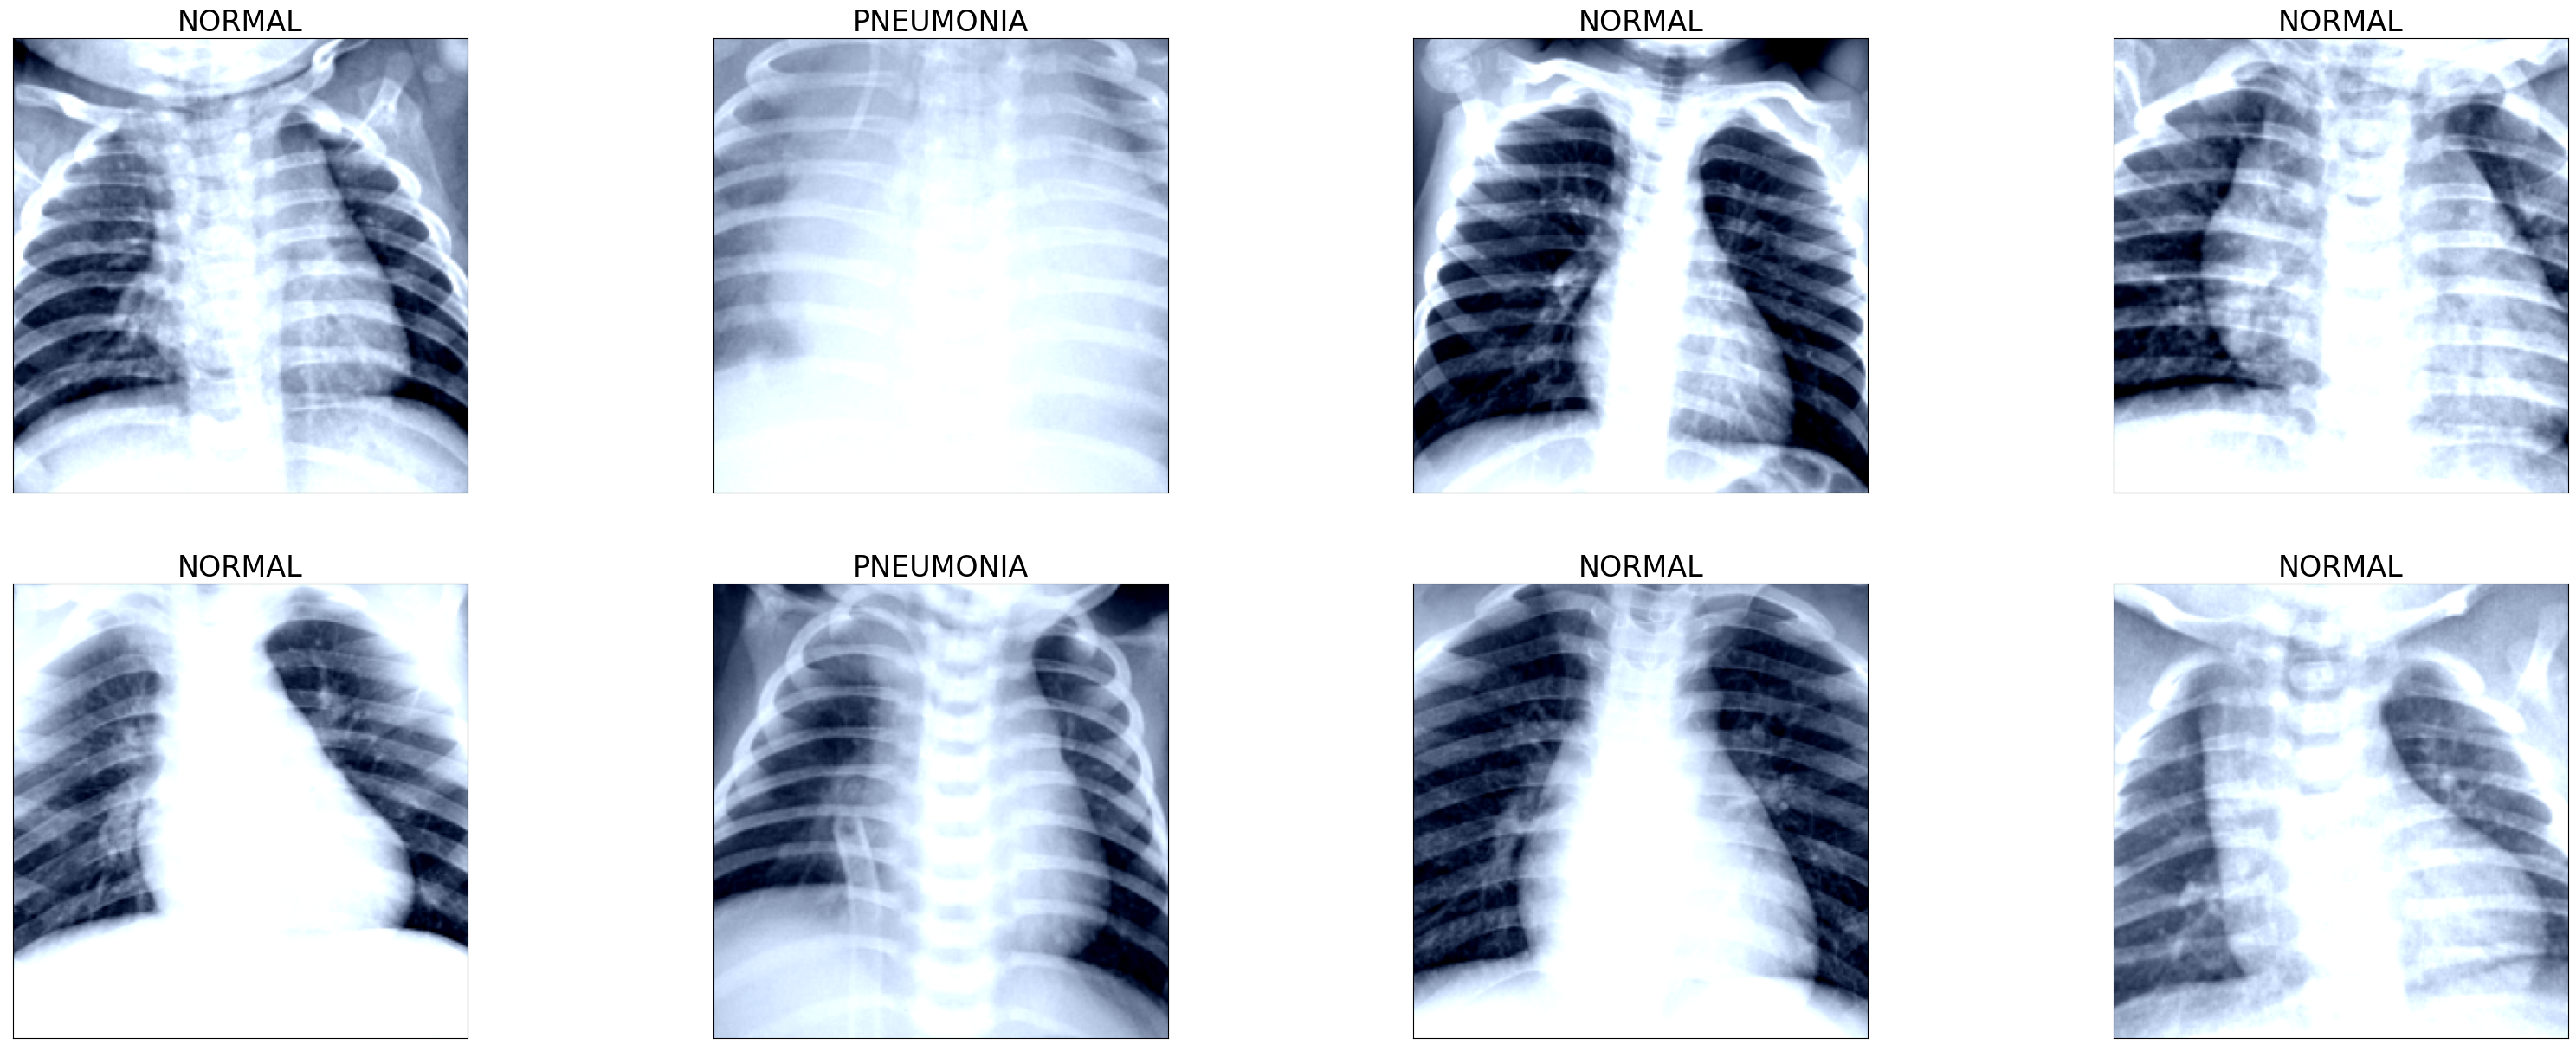

In [33]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
train_on_gpu = True if torch.cuda.is_available() else False
if train_on_gpu:
    images = images.cuda()


# plot the images in the batch, along with predicted labels
fig = plt.figure(figsize=(40, 15))
for idx in np.arange(8):
    ax = fig.add_subplot(2, int(8/2), idx+1, xticks=[], yticks=[])
    img = images.cpu()[idx]
    img = img * 0.5 + 0.5
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img, cmap="gray")
    ax.set_title(test_data.classes[labels[idx].item()], fontsize=24)

In [34]:
## Creating a residual block

class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, use_1x1_conv=False,
                 stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
                
        if use_1x1_conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                  stride=stride)
        else:
            self.conv3 = None
            
    def forward(self, x):
        y = self.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))

        
        if self.conv3:
            ## dimensions will be matched
            x = self.conv3(x)
            
        ## returns f(x) + x
        return self.relu(x+y)

In [35]:
output_size = ModelParams.OUTPUT_SIZE
class ResNet18(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64,
                              kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.get_renset_layer(64, 64, 2, first_block=True)
        self.layer2 = self.get_renset_layer(64, 128, 2)
        self.layer3 = self.get_renset_layer(128, 256, 2)
        self.layer4 = self.get_renset_layer(256, 512, 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, output_size)
        
        
    
    def get_renset_layer(self, in_channels, out_channels,
                         num_residual_blocks, first_block=False):
        
        layers = list()
        
        for i in range(num_residual_blocks):
            if i == 0 and not first_block:
                layers.append(ResidualBlock(in_channels, out_channels,
                                use_1x1_conv=True, stride=2))
            else:
                layers.append(ResidualBlock(in_channels, out_channels,
                                use_1x1_conv=False, stride=1))
            in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        
        return x

In [36]:
use_pretrained = Config.use_pretrained
if use_pretrained:
    Config.logger.info("Using pre-trained model...")
    # Load pre-trained ResNet18 model
    resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

    # Freeze all layers except the last one
    for param in resnet18.parameters():
        param.requires_grad = False

    num_ftrs = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_ftrs, 2)
else:
    Config.logger.info("Using custom model...")
    resnet18 = ResNet18() # Load custom resnet

2023-05-07 05:31:11,324 - __main__ - INFO - Using custom model...
2023-05-07 05:31:11,324 - __main__ - INFO - Using custom model...


In [37]:
if Config.CUDA_AVAILABLE:
    Config.logger.info("Moving model to cuda...")
    resnet18 = resnet18.cuda()

2023-05-07 05:31:11,561 - __main__ - INFO - Moving model to cuda...
2023-05-07 05:31:11,561 - __main__ - INFO - Moving model to cuda...


In [38]:
# Select appropriate criterion
if CRITERION_PARAMS.loss_func == "CrossEntropyLoss":
    criterion = nn.CrossEntropyLoss()

# Select appropriate optimizer
if OPTIMIZER_PARAMS.optimizer_name == "Adam":
    optimizer = optim.Adam(resnet18.parameters(), lr=OPTIMIZER_PARAMS.lr[0])
if OPTIMIZER_PARAMS.optimizer_name == "SGD":
    optimizer = optim.SGD(resnet18.parameters(), lr=OPTIMIZER_PARAMS.lr[0])

In [39]:
n_epochs = TRAIN_PARAMS.epochs
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
valid_loss_min = np.inf

for e in range(n_epochs):
    train_loss = 0
    train_correct = 0
    valid_loss = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0
    
    resnet18.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for img, label in tepoch:
            
            if train_on_gpu:
                img = img.cuda()
                label = label.cuda()
            
            optimizer.zero_grad()
            
            predicted_label = resnet18(img)
            loss = criterion(predicted_label, label)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(predicted_label.data, 1)
            train_correct += (predicted == label).sum().item()
            train_total += label.size(0)
            tepoch.set_postfix(loss=train_loss/len(train_loader))
    
    resnet18.eval()
    
    with tqdm(valid_loader, unit="batch") as tepoch:
        for img, label in tepoch:
            
            if train_on_gpu:
                img = img.cuda()
                label = label.cuda()
            
            predicted_label = resnet18(img)
            loss = criterion(predicted_label, label)
            
            valid_loss += loss.item()
            _, predicted = torch.max(predicted_label.data, 1)
            valid_correct += (predicted == label).sum().item()
            valid_total += label.size(0)
            tepoch.set_postfix(loss=valid_loss/len(valid_loader))
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = 100 * train_correct / train_total
    train_accs.append(train_acc)
    
    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)
    valid_acc = 100 * valid_correct / valid_total
    valid_accs.append(valid_acc)
    
    print(f"Epoch: {e+1} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% \
          Valid Loss: {valid_loss:.4f} Valid Acc: {valid_acc:.2f}%")
    
    if valid_loss < valid_loss_min:
        print("Validation Loss Decreased From {} to {}".format(valid_loss_min, valid_loss))
        valid_loss_min = valid_loss
        torch.save(resnet18.state_dict(), "resnet_.pth")
        print("Saving Best Model")

100%|██████████| 66/66 [00:01<00:00, 49.10batch/s, loss=0.371] 


Epoch: 1 Train Loss: 0.3620 Train Acc: 84.28%           Valid Loss: 0.3708 Valid Acc: 84.05%
Validation Loss Decreased From inf to 0.3708273722141078
Saving Best Model


100%|██████████| 66/66 [00:01<00:00, 49.15batch/s, loss=0.268] 


Epoch: 2 Train Loss: 0.2835 Train Acc: 87.84%           Valid Loss: 0.2679 Valid Acc: 89.97%
Validation Loss Decreased From 0.3708273722141078 to 0.26789504690378
Saving Best Model


100%|██████████| 66/66 [00:01<00:00, 48.30batch/s, loss=0.401] 


Epoch: 3 Train Loss: 0.2358 Train Acc: 90.30%           Valid Loss: 0.4012 Valid Acc: 85.67%


100%|██████████| 66/66 [00:01<00:00, 48.35batch/s, loss=0.302] 


Epoch: 4 Train Loss: 0.1996 Train Acc: 91.78%           Valid Loss: 0.3022 Valid Acc: 88.83%


100%|██████████| 66/66 [00:01<00:00, 47.70batch/s, loss=0.411] 


Epoch: 5 Train Loss: 0.1561 Train Acc: 94.03%           Valid Loss: 0.4105 Valid Acc: 84.91%


100%|██████████| 66/66 [00:01<00:00, 47.06batch/s, loss=0.387] 


Epoch: 6 Train Loss: 0.1256 Train Acc: 95.29%           Valid Loss: 0.3866 Valid Acc: 85.86%


100%|██████████| 66/66 [00:01<00:00, 48.79batch/s, loss=0.347] 


Epoch: 7 Train Loss: 0.1055 Train Acc: 96.08%           Valid Loss: 0.3474 Valid Acc: 88.54%


100%|██████████| 66/66 [00:01<00:00, 49.32batch/s, loss=0.359] 


Epoch: 8 Train Loss: 0.0762 Train Acc: 97.16%           Valid Loss: 0.3593 Valid Acc: 88.54%


100%|██████████| 66/66 [00:01<00:00, 48.16batch/s, loss=0.597] 


Epoch: 9 Train Loss: 0.0639 Train Acc: 97.68%           Valid Loss: 0.5967 Valid Acc: 85.77%


100%|██████████| 66/66 [00:01<00:00, 49.19batch/s, loss=0.464] 


Epoch: 10 Train Loss: 0.0492 Train Acc: 98.11%           Valid Loss: 0.4643 Valid Acc: 87.49%


100%|██████████| 66/66 [00:01<00:00, 49.12batch/s, loss=0.404] 


Epoch: 11 Train Loss: 0.0427 Train Acc: 98.21%           Valid Loss: 0.4041 Valid Acc: 88.35%


100%|██████████| 66/66 [00:01<00:00, 49.24batch/s, loss=0.447] 

Epoch: 12 Train Loss: 0.0555 Train Acc: 97.83%           Valid Loss: 0.4469 Valid Acc: 87.97%


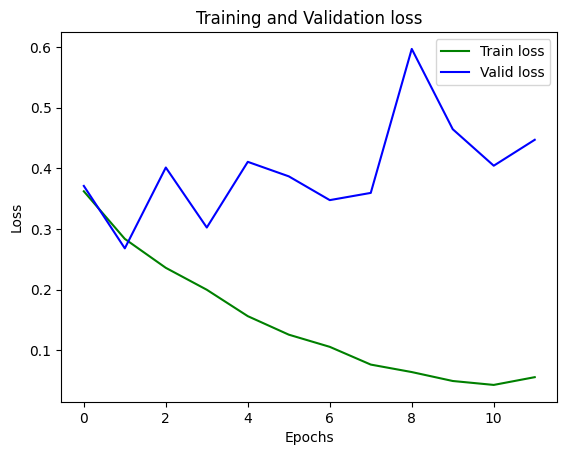

In [40]:
epochs = range(0, n_epochs)
plt.plot(epochs, train_losses, 'g', label='Train loss')
plt.plot(epochs, valid_losses, 'b', label='Valid loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

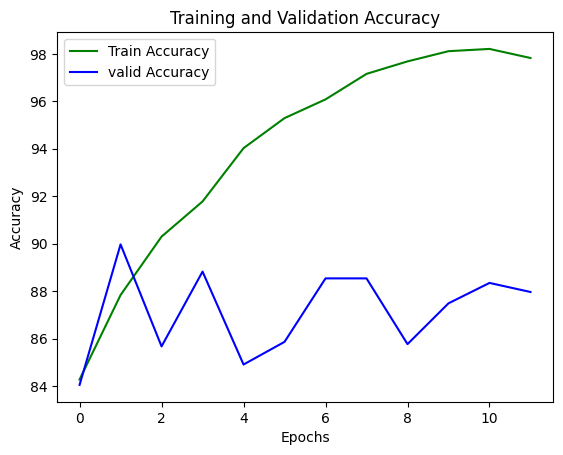

In [41]:
plt.plot(epochs, train_accs, 'g', label='Train Accuracy')
plt.plot(epochs, valid_accs, 'b', label='valid Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
correct = 0
total = 0


# set model to evaluation mode
resnet18.eval()

# loop through test_loader and compute predictions and true labels
preds = []
true_labels = []
with torch.no_grad(), tqdm(total=len(test_loader)) as pbar:
    for images, labels in test_loader:
        if train_on_gpu:
            images = images.cuda()
            labels = labels.cuda()
        output = resnet18(images)
        _, preds_tensor = torch.max(output, 1)
        predictions = preds_tensor.cpu().numpy()
        correct += (predictions == labels.cpu().numpy()).sum().item()
        total += labels.size(0)
        preds.extend(preds_tensor.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        pbar.update(1)

# calculate testing accuracy
accuracy = 100 * correct / total
print(f"Testing Accuracy: {accuracy:.2f}%")

# calculate precision, recall, and f1-score
report = classification_report(true_labels, preds, target_names=["Normal", "Pneumonia"])
print(report)

100%|██████████| 39/39 [00:16<00:00,  2.38it/s]

Testing Accuracy: 85.26%
              precision    recall  f1-score   support

      Normal       0.90      0.68      0.78       234
   Pneumonia       0.83      0.96      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.82      0.83       624
weighted avg       0.86      0.85      0.85       624



In [43]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Paired):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

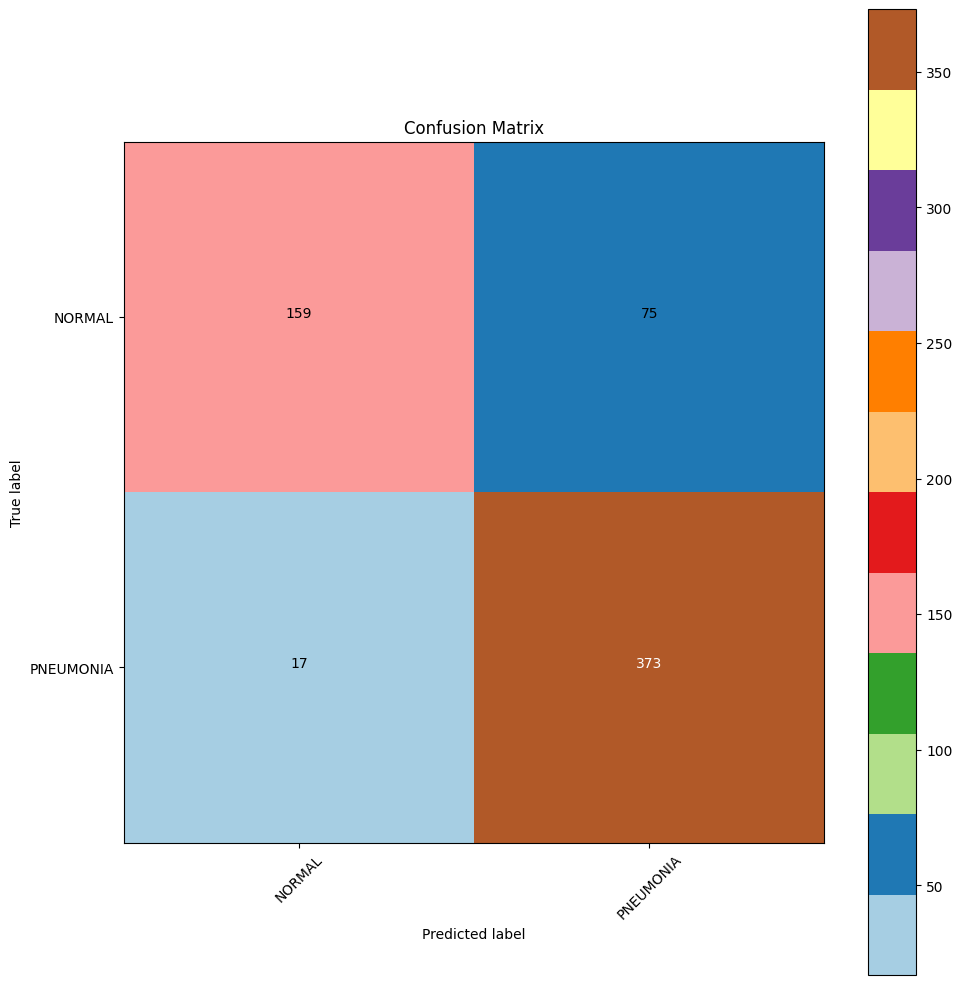

In [44]:
cm = confusion_matrix(true_labels, preds)
target_names = ["NORMAL", "PNEUMONIA"]
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

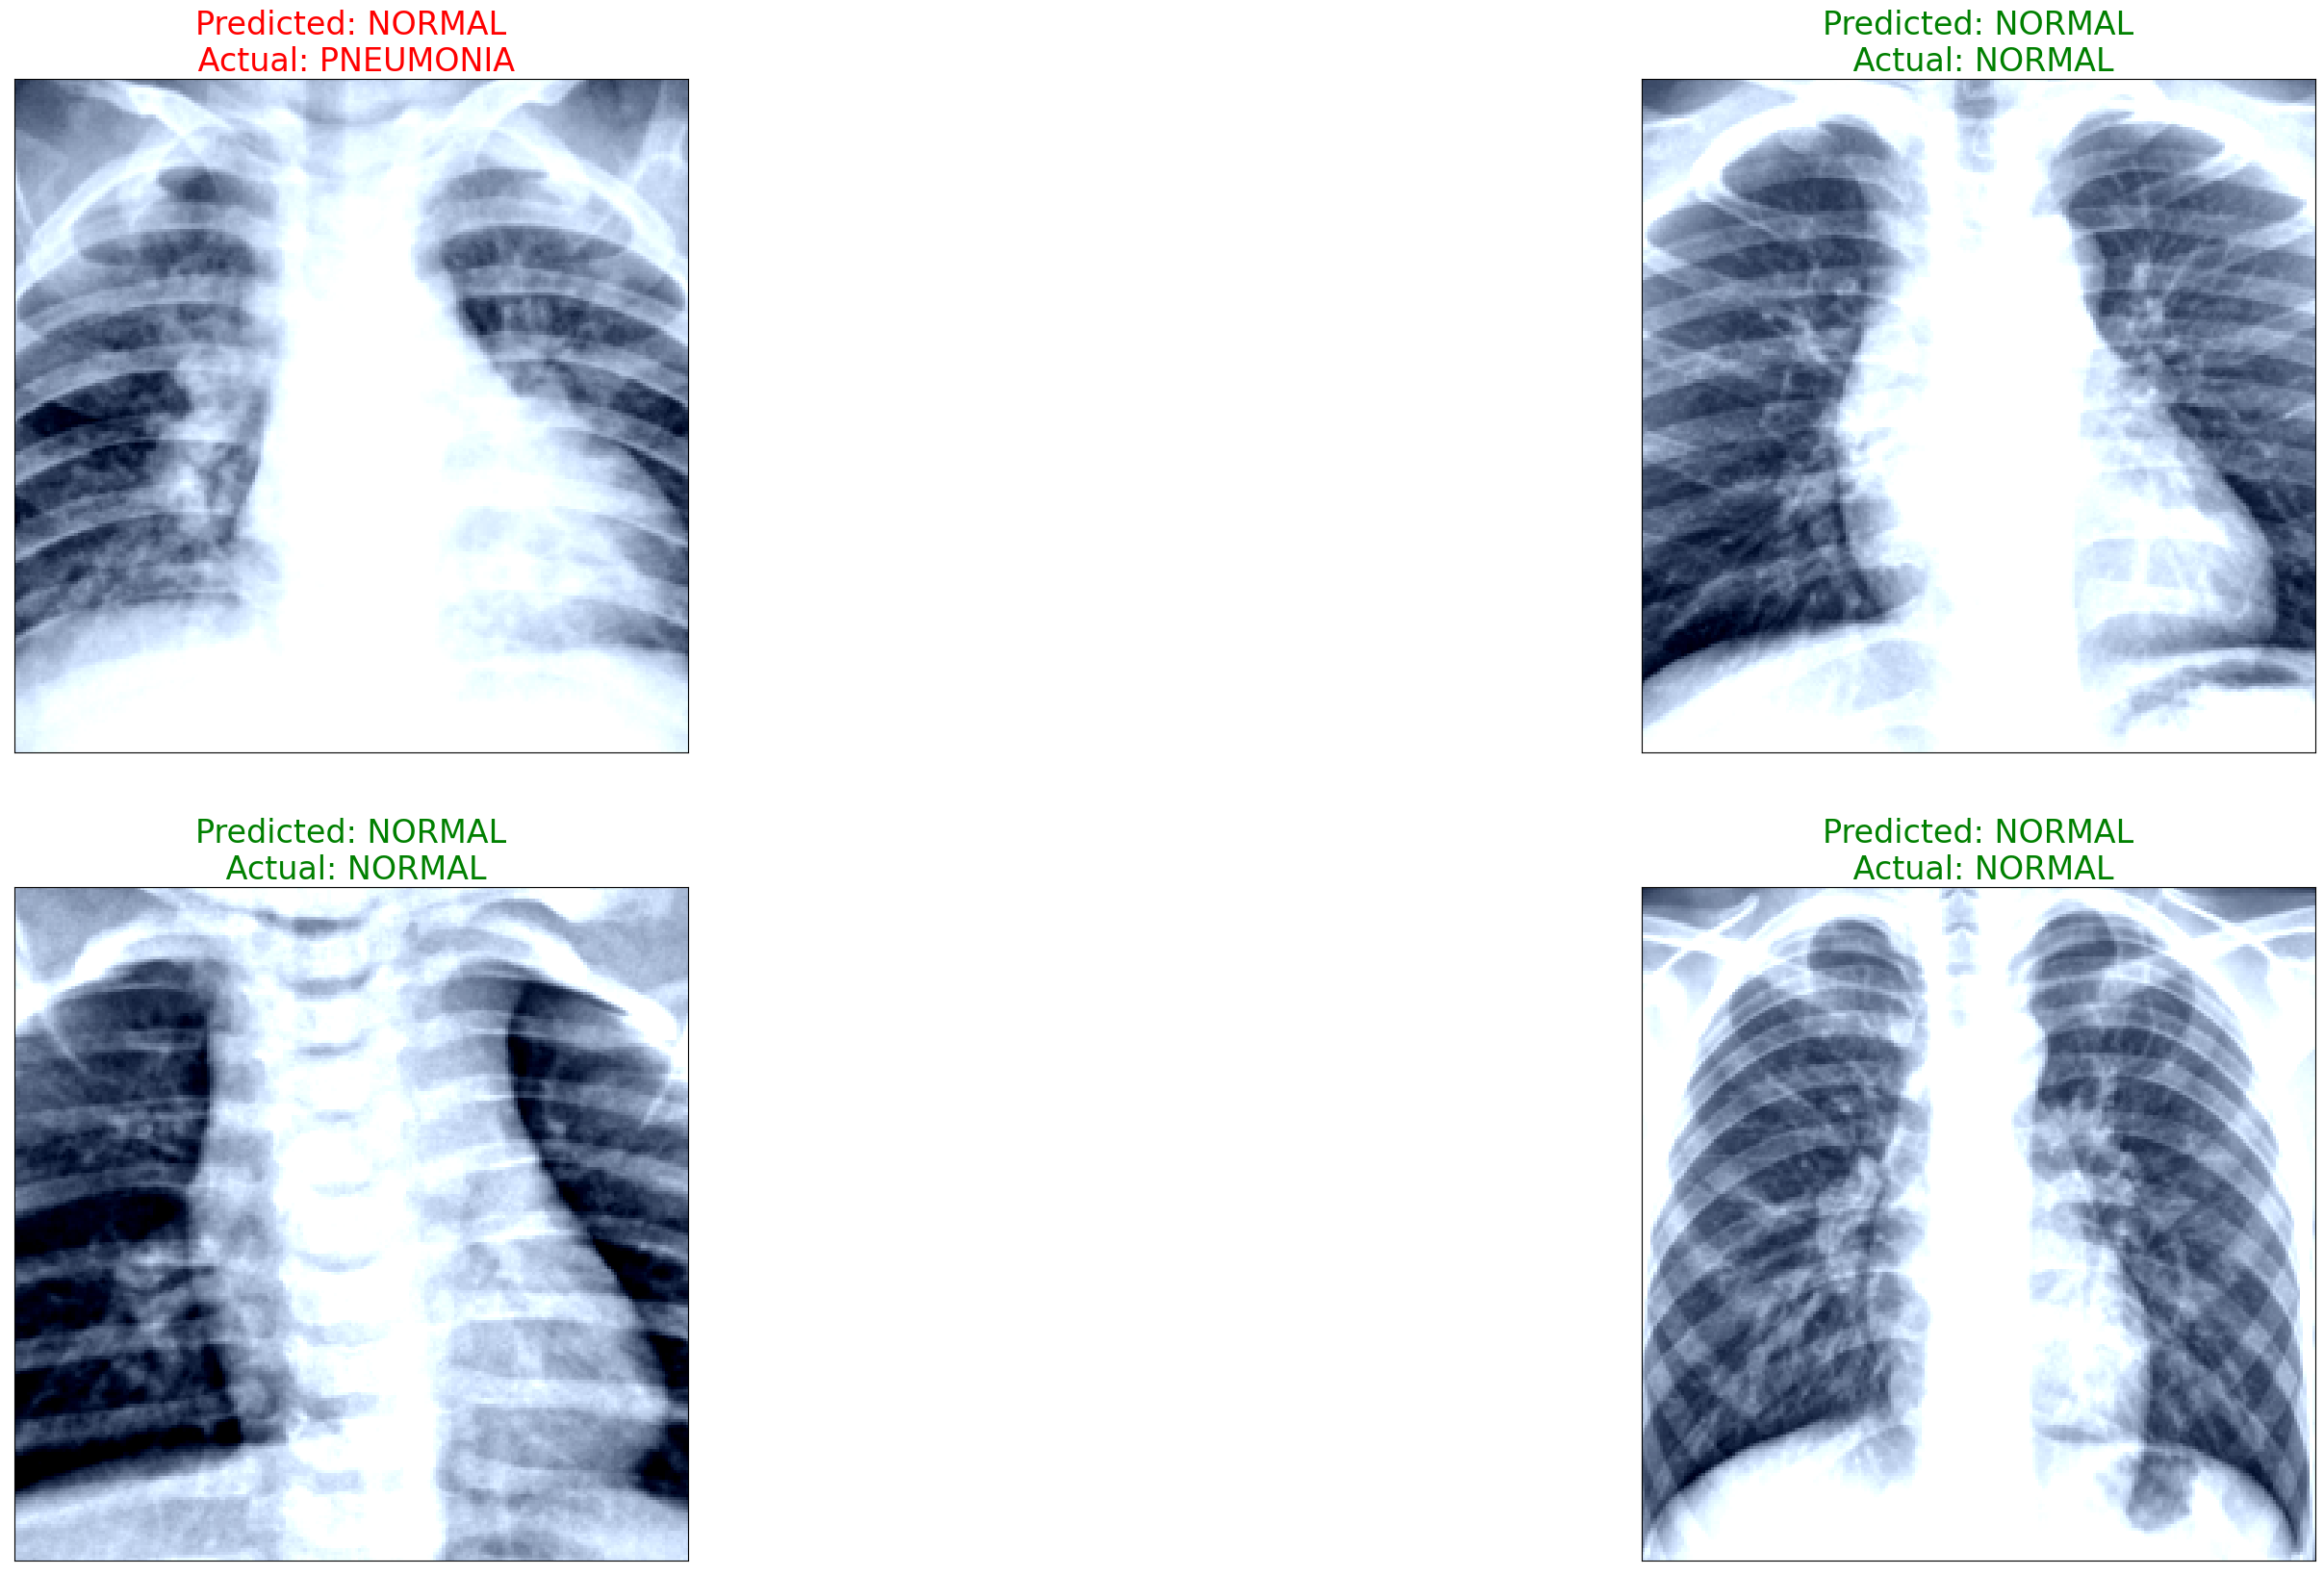

In [55]:
mapping = {
    1: "PNEUMONIA",
    0: "NORMAL"
}

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = resnet18(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())



# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(40, 20))
for idx in np.arange(4):
    ax = fig.add_subplot(2, int(4/2), idx+1, xticks=[], yticks=[])
    img = images.cpu()[idx]
    img = img * 0.5 + 0.5
    img = np.transpose(img, (1, 2, 0))
    img = img.reshape((224,224, 3))
    plt.imshow(img, cmap="gray")
    ax.set_title("Predicted: {}\n Actual: {}".format(mapping[preds[idx].item()],
                                  mapping[labels[idx].item()]),
                 fontsize=24,
                 color=("green" if preds[idx]==labels[idx].item() else "red")) 

In [46]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

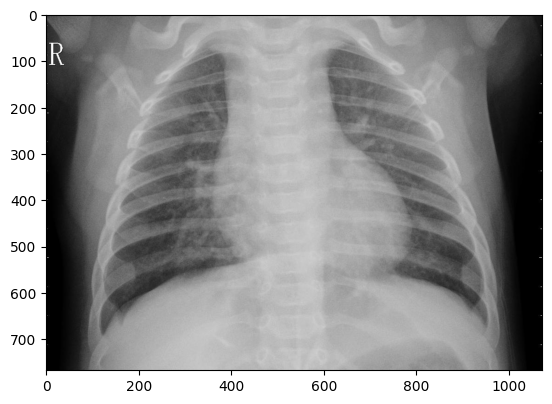

In [47]:
image = Image.open(str('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg')).convert("RGB")
plt.imshow(image, cmap="gray")

In [48]:
from torchvision.models import resnet18, ResNet18_Weights

# Load pre-trained ResNet18 model
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all layers except the last one
for param in resnet18.parameters():
    param.requires_grad = False

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


In [49]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(resnet18.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print(conv_layers)

Total convolution layers: 17
[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(256

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet18.to(device)

image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [51]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

17
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])


In [52]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


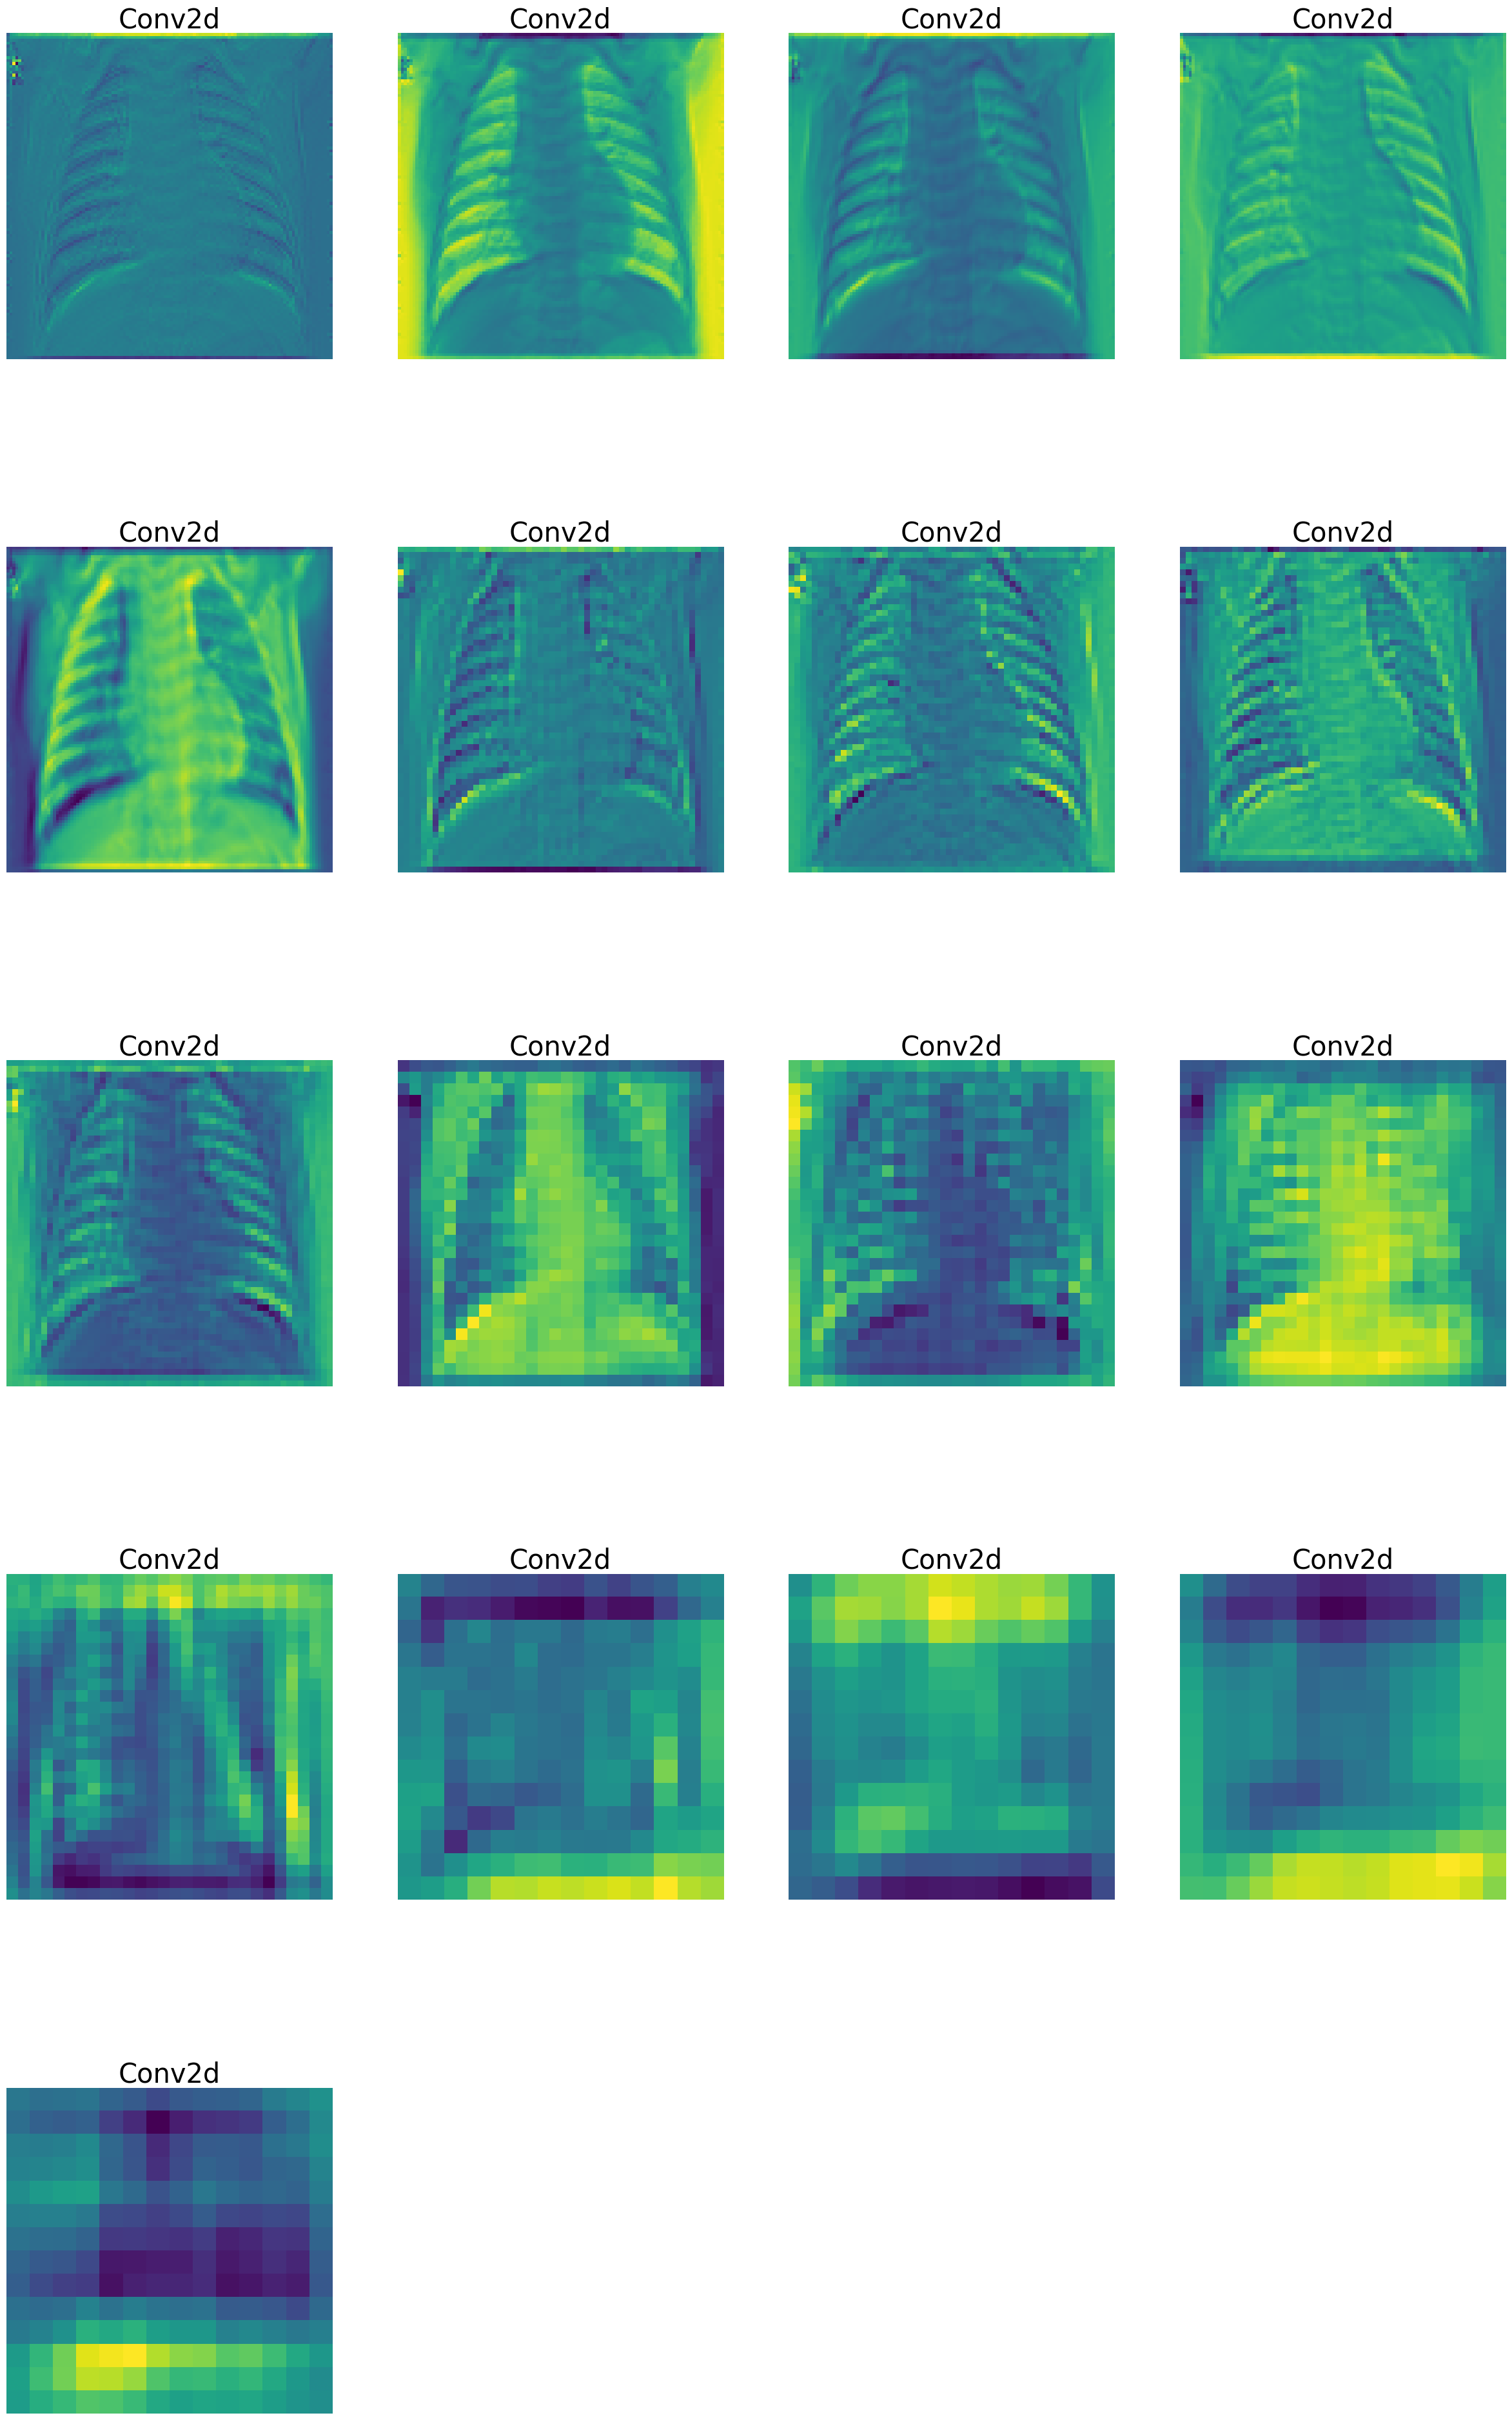

In [53]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')